#Satellite Image Classification with Convolutional Neural Networks

by Madelyn Silveira, Zivanai Mutaya, James Chillery

April 2025

For this project, we will use the Functional Map of the World dataset, created by the Intelligence Advanced Research Projects Activity (IARPA). We download it from their github: https://github.com/fMoW/dataset.

@inproceedings{fmow2018,
  title={Functional Map of the World},
  author={Christie, Gordon and Fendley, Neil and Wilson, James and Mukherjee, Ryan},
  booktitle={CVPR},
  year={2018}
}

The full dataset contains terabytes of multi-channel data. We will use a simplified version with only rgb channels. Since this simplified version is still around 200GB -- exceeding the storage of collab -- we will stream the data from AWS S3, filtering for relevant classes as we go. We chose target classes that we thought might be useful to characterize energy consumption since 2002.

**Define Target Classes**

The focus of this project is to analyze energy production and distribution, so we will focus on classes pertaining to that domain. Reducing the classes also significantly reduces computational load.

In [47]:
import os

import matplotlib.pyplot as plt
import tarfile
import boto3
import bz2
import json
import pprint

from pathlib import Path
from botocore import UNSIGNED
from botocore.config import Config
from PIL import Image, ImageDraw

In [ ]:
# this names all classes in the dataset
all_classes = [
    "airport", "airport_hangar", "airport_terminal", "amusement_park",
    "aquaculture", "archaeological_site", "barn", "border_checkpoint",
    "burial_site", "car_dealership", "construction_site", "crop_field",
    "dam", "debris_or_rubble", "educational_institution", "electric_substation",
    "factory_or_powerplant", "fire_station", "flooded_road", "fountain",
    "gas_station", "golf_course", "ground_transportation_station", "helipad",
    "hospital", "impoverished_settlement", "interchange", "lake_or_pond",
    "lighthouse", "military_facility", "multi-unit_residential",
    "nuclear_powerplant", "office_building", "oil_or_gas_facility", "park",
    "parking_lot_or_garage", "place_of_worship", "police_station", "port",
    "prison", "race_track", "railway_bridge", "recreational_facility",
    "road_bridge", "runway", "shipyard", "shopping_mall",
    "single-unit_residential", "smokestack", "solar_farm", "space_facility",
    "stadium", "storage_tank", "surface_mine", "swimming_pool", "toll_booth",
    "tower", "tunnel_opening", "waste_disposal", "water_treatment_facility",
    "wind_farm", "zoo"]

# these are the classes we want to explore for this project
target_classes = [
    "electric_substation", "factory_or_powerplant", "gas_station",
    "nuclear_powerplant", "oil_or_gas_facility", "solar_farm", "space_facility",
    "waste_disposal", "water_treatment_facility", "wind_farm"]

# examples are labeled with the numerical value for each class
target_ids = []
print("Target Classes:\n")
for target_class in target_classes:
    try:
        idx = all_classes.index(target_class)
        target_ids.append(idx)
        print(f"{idx}: {target_class}")
    except ValueError:
        print(f"{target_class} not found in all_classes")

print(f"\nLength: {len(target_ids)}")

# view numbers for all classes
# for idx, c in enumerate(all_classes):
#     print(f"{idx}: {c}")

Target Classes:

15: electric_substation
16: factory_or_powerplant
20: gas_station
31: nuclear_powerplant
33: oil_or_gas_facility
49: solar_farm
50: space_facility
58: waste_disposal
59: water_treatment_facility
60: wind_farm

Length: 10


In [4]:
!pip3 install boto3

In [ ]:
# using Amazon Single Storage Service with a guest account
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'spacenet-dataset'
prefix = 'Hosted-Datasets/fmow/fmow-rgb/'

# view the README.md from the S3 bucket
s3.download_file(bucket_name, prefix + 'README.md', 'README.md')
with open('README.md', 'r') as f:
    print(f.read())

# Functional Map of the World (fMoW) RGB Dataset
The data in this bucket represents the JPEG-compressed RGB version of the dataset that was created for the fMoW Challenge. There is another bucket located at s3://spacenet-dataset/fmow/fmow-full that contains the same imagery as this bucket except that all imagery is in a less-compressed TIFF format and multispectral imagery contains 4 or 8 channels of information. The fMoW-full dataset is significantly larger in size, but recommended for those of you who would like less compressed imagery and/or intend to utilize multispectral information.

## The Problem
Intelligence analysts, policy makers, and first responders around the world rely on geospatial land use data to inform crucial decisions about global defense and humanitarian activities. Historically, analysts have manually identified and classified geospatial information by comparing and analyzing satellite images, but that process is time consuming and insufficient to support disaste

In [6]:
# download and load the filed directory
s3.download_file(bucket_name, prefix + 'manifest.json.bz2', 'manifest.json.bz2')
with bz2.open('manifest.json.bz2', 'rt') as f:
    manifest = json.load(f)

# view the beginning structure
pprint.pprint(manifest[:20])

['CHANGELOG.md',
 'IARPA-fMoW.pdf',
 'LICENSE',
 'README.md',
 'fMoW-rgb_seqandgt_v1.2.1.torrent',
 'fMoW-rgb_test_v1.0.0.torrent',
 'fMoW-rgb_trainval_v1.0.0.torrent',
 'fMoW-rgb_val_sample_v1.1.0.torrent',
 'groundtruth.tar.bz2',
 'manifest.json.bz2',
 'seq/0000000/0000000_0_msrgb.jpg',
 'seq/0000000/0000000_0_msrgb.json',
 'seq/0000000/0000000_0_rgb.jpg',
 'seq/0000000/0000000_0_rgb.json',
 'seq/0000000/0000000_2_msrgb.jpg',
 'seq/0000000/0000000_2_msrgb.json',
 'seq/0000000/0000000_2_rgb.jpg',
 'seq/0000000/0000000_2_rgb.json',
 'seq/0000000/0000000_4_msrgb.jpg',
 'seq/0000000/0000000_4_msrgb.json']


In [7]:
from collections import defaultdict

# let's check the folder structure of the manifest
folder_counts = defaultdict(int)
for path in manifest:
    if '/' in path:
        folder = path.split('/')[0]
        folder_counts[folder] += 1
    else:
        folder_counts['[root]'] += 1

for folder, count in folder_counts.items():
    print(f"{folder}/ : {count} items")

[root]/ : 11 items
seq/ : 215040 items
test/ : 213892 items
train/ : 1454288 items
val/ : 212162 items


The seq folder contains temporal sequences of photos. It is useful for analyzing things like flooded roads. We will not be using it for our project.

In [8]:
# how are those folders structured?
subfolder_counts = defaultdict(int)
for path in manifest:
    parts = path.split('/')
    if len(parts) > 1:
        subfolder = '/'.join(parts[:2])
        subfolder_counts[subfolder] += 1
for subfolder, count in subfolder_counts.items():
    print(f"{subfolder}/ : {count} items")

seq/0000000/ : 12 items
seq/0000001/ : 52 items
seq/0000002/ : 4 items
seq/0000003/ : 4 items
seq/0000004/ : 4 items
seq/0000005/ : 12 items
seq/0000006/ : 4 items
seq/0000007/ : 12 items
seq/0000008/ : 28 items
seq/0000009/ : 32 items
seq/0000010/ : 8 items
seq/0000011/ : 8 items
seq/0000012/ : 4 items
seq/0000013/ : 8 items
seq/0000014/ : 4 items
seq/0000015/ : 8 items
seq/0000016/ : 4 items
seq/0000017/ : 40 items
seq/0000018/ : 20 items
seq/0000019/ : 4 items
seq/0000020/ : 56 items
seq/0000021/ : 8 items
seq/0000022/ : 8 items
seq/0000023/ : 16 items
seq/0000024/ : 20 items
seq/0000025/ : 4 items
seq/0000026/ : 12 items
seq/0000027/ : 16 items
seq/0000028/ : 40 items
seq/0000029/ : 40 items
seq/0000030/ : 36 items
seq/0000031/ : 8 items
seq/0000032/ : 8 items
seq/0000033/ : 8 items
seq/0000034/ : 4 items
seq/0000035/ : 4 items
seq/0000036/ : 36 items
seq/0000037/ : 36 items
seq/0000038/ : 12 items
seq/0000039/ : 4 items
seq/0000040/ : 8 items
seq/0000041/ : 12 items
seq/0000042/ :

Dowload the training and validation to local machine. Only 
download folders of classes we need.

In [ ]:
# we need to build a list of the folder paths we want.
target_path_prefixes = []
for category in target_classes:
    target_path_prefixes.append(f"train/{category}/")
    target_path_prefixes.append(f"val/{category}/")
print(target_path_prefixes)

def matches_target_prefixes(file_path, target_folders):
    return any(file_path.startswith(folder) for folder in target_folders)

# we can query this function like so
positive_ex = 'train/wind_farm/'
negative_ex = 'val/tower/'

print(f"Positive: {matches_target_prefixes(positive_ex, target_path_prefixes)}")
print(f"Negative: {matches_target_prefixes(negative_ex, target_path_prefixes)}")

['train/electric_substation/', 'val/electric_substation/', 'train/factory_or_powerplant/', 'val/factory_or_powerplant/', 'train/gas_station/', 'val/gas_station/', 'train/nuclear_powerplant/', 'val/nuclear_powerplant/', 'train/oil_or_gas_facility/', 'val/oil_or_gas_facility/', 'train/solar_farm/', 'val/solar_farm/', 'train/space_facility/', 'val/space_facility/', 'train/waste_disposal/', 'val/waste_disposal/', 'train/water_treatment_facility/', 'val/water_treatment_facility/', 'train/wind_farm/', 'val/wind_farm/']
Positive: True
Negative: False


Each example has 4 files: the multispectral rgb jpeg and associated json as well as the regular rgb and associated json. We will start with one version and compare with the other if time allows. For now, let's look at the difference.

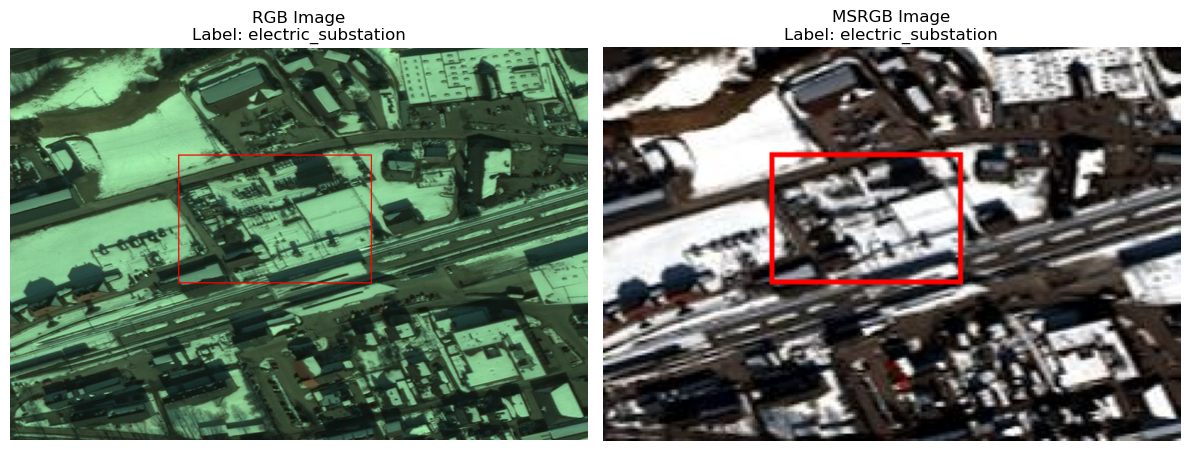

In [ ]:
def load_img(path):

    # parse the paths from the input path
    img_path = f"{path}.jpg"
    json_path = f"{path}.json"

    # load the image and metadata
    img_local = os.path.basename(img_path)
    json_local = os.path.basename(json_path)

    s3.download_file(bucket_name, prefix + img_path, img_local)
    s3.download_file(bucket_name, prefix + json_path, json_local)

    img = Image.open(img_local).convert("RGB")
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    draw = ImageDraw.Draw(img)
    ids = []

    for box in metadata.get("bounding_boxes", []):

        # get the label for this id
        try:
            ids.append(box["category"])
        except ValueError:
            ids.append("unkown")

        # draw the box within the image
        x_min, y_min, width, height = box["box"]
        draw.rectangle([x_min, y_min, x_min + width, y_min + height], outline="red", width=2)

    return img, ids

# load both spectral versions and their annotations
img_rgb, ids_rgb = load_img("train/electric_substation/electric_substation_0/electric_substation_0_0_rgb")
img_msrgb, ids_msrgb = load_img("train/electric_substation/electric_substation_0/electric_substation_0_0_msrgb")

# plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title(f"RGB Image\nLabel: {ids_rgb[0]}")
axes[0].axis('off')
axes[1].imshow(img_msrgb)
axes[1].set_title(f"MSRGB Image\nLabel: {ids_msrgb[0]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Notice how the bounding box in the multispectral image is thicker. This is because the "width" attribute is pixel-dependent, and the msrgb images are scaled down to maintain picture integrity at a lower resolution.

In [ ]:
# compare the image sizes
print("RGB size:", img_rgb.size)
print("MSRGB size:", img_msrgb.size)

RGB size: (942, 640)
MSRGB size: (236, 161)


We will train on msrg images to start because they have a lower computational overhead.

One more thing to note before we are ready for download: The images come with bounding boxes indicating where the class instance is in the picture. Because this specificity is available to us, we intend to use it. Since, however, it might be interesting to compare if some models work better with more context, we will look into both.

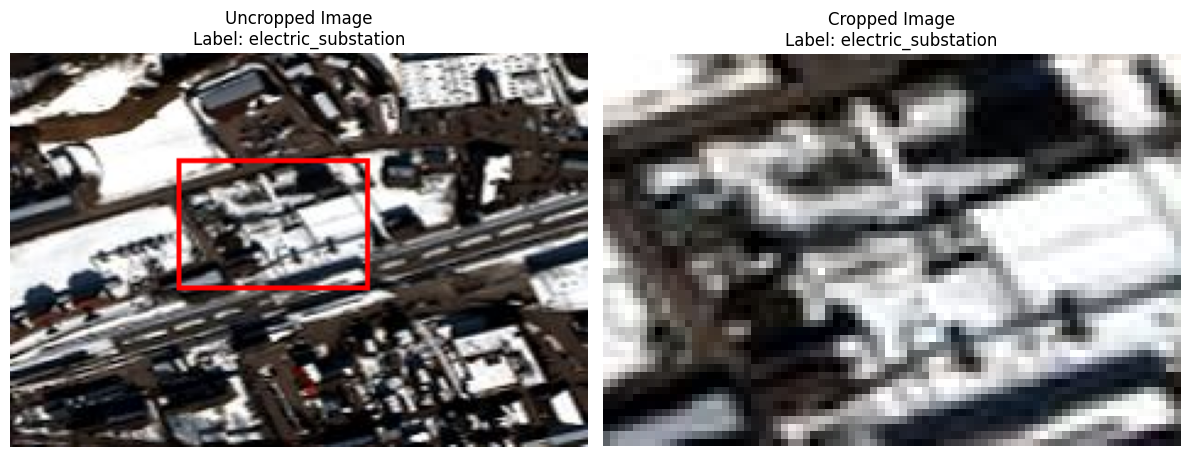

In [ ]:
def load_and_crop(path):

    # parse the paths from the input path
    img_path = f"{path}.jpg"
    json_path = f"{path}.json"

    # load the image and metadata
    img_local = os.path.basename(img_path)
    json_local = os.path.basename(json_path)

    s3.download_file(bucket_name, prefix + img_path, img_local)
    s3.download_file(bucket_name, prefix + json_path, json_local)

    img = Image.open(img_local).convert("RGB")
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    crops = []
    labels = []

    for i, box in enumerate(metadata.get("bounding_boxes", [])):
        label = box["category"]
        x_min, y_min, width, height = box['box']
        cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
        crops.append(cropped)
        labels.append(label)

    return crops, labels


# load both spectral versions and their annotations
boxed_img, boxed_id = load_img("train/electric_substation/electric_substation_0/electric_substation_0_0_msrgb")
cropped_img, cropped_id = load_and_crop("train/electric_substation/electric_substation_0/electric_substation_0_0_msrgb")

# plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(boxed_img)
axes[0].set_title(f"Uncropped Image\nLabel: {boxed_id[0]}")
axes[0].axis('off')
axes[1].imshow(cropped_img[0])
axes[1].set_title(f"Cropped Image\nLabel: {cropped_id[0]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

The tensorflow architectural pipeline requires square images. Instead of cropping the exact bounding box, we will crop the tightest fitting square around the bounding box.

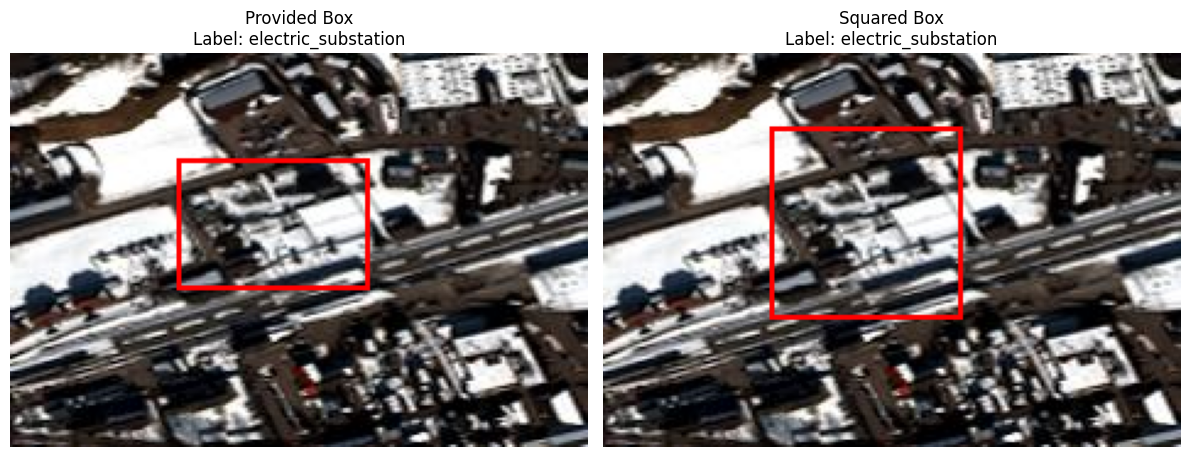

In [ ]:
def load_img_square(path):

    # parse the paths from the input path
    img_path = f"{path}.jpg"
    json_path = f"{path}.json"

    # load the image and metadata
    img_local = os.path.basename(img_path)
    json_local = os.path.basename(json_path)

    s3.download_file(bucket_name, prefix + img_path, img_local)
    s3.download_file(bucket_name, prefix + json_path, json_local)

    img = Image.open(img_local).convert("RGB")
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    draw = ImageDraw.Draw(img)
    ids = []

    for box in metadata.get("bounding_boxes", []):

        # get the label for this id
        try:
            ids.append(box["category"])
        except ValueError:
            ids.append("unkown")

        # draw the box, squared at its center
        x_min, y_min, width, height = box["box"]
        max_dim = max(width, height)
        x_min = x_min + (width - max_dim) // 2
        y_min = y_min + (height - max_dim) // 2
        width, height = max_dim, max_dim

        draw.rectangle([x_min, y_min, x_min + width, y_min + height], outline="red", width=2)

    return img, ids

# load both spectral versions and their annotations
img_rgb, ids_rgb = load_img("train/electric_substation/electric_substation_0/electric_substation_0_0_msrgb")
img_msrgb, ids_msrgb = load_img_square("train/electric_substation/electric_substation_0/electric_substation_0_0_msrgb")

# plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title(f"Provided Box\nLabel: {ids_rgb[0]}")
axes[0].axis('off')
axes[1].imshow(img_msrgb)
axes[1].set_title(f"Squared Box\nLabel: {ids_msrgb[0]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()


Pillow's behavior if you try to extend the square beyond the dimensions of the image is to truncate the crop at the edges of the image -- so those images wouldn't come out square. When we feed to tensorflow, it defaults transforms images to be in a square via aspect ratio distortion. We'll keep track of how many examples this occurs for, but it shouldn't be a problem overall.

In [ ]:
def crop_and_download(file_stem, missing_files, missing_count):

    # parse the paths from the input path
    img_path = f"{file_stem}.jpg"
    json_path = f"{file_stem}.json"

    # load the image and metadata
    img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(img_path)
    json_local = Path('fmow_msrgb_dataset_cropped/metadata') / Path(json_path)

    # download the images to their respective directories
    img_local.parent.mkdir(parents=True, exist_ok=True)
    json_local.parent.mkdir(parents=True, exist_ok=True)
    s3.download_file(bucket_name, prefix + img_path, str(img_local))
    s3.download_file(bucket_name, prefix + json_path, str(json_local))

    # we need to download and open the image before we can crop
    img = Image.open(img_local).convert("RGB")
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    multiple_bounding_boxes = []

    for i, box in enumerate(metadata.get("bounding_boxes", [])):

        # keep track of multiple bounding boxes
        if i >= 1:
            multiple_bounding_boxes.append(img_local)
            img_path = f"{file_stem}_{i}.jpg"
            img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(img_path)

        # resize to be squared at box center
        x_min, y_min, width, height = box["box"]
        max_dim = max(width, height)
        x_min = x_min + (width - max_dim) // 2
        y_min = y_min + (height - max_dim) // 2
        width, height = max_dim, max_dim

        # crop the image overwrite the uncropped jpg
        cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
        cropped.save(img_local, format="JPEG")

    return missing_files, missing_count, multiple_bounding_boxes

### Download the Test and Val Data

In [ ]:
def download_fmow(manifest, target_paths, cropped=True):

    manifest_set = set(manifest)
    multiple_bounding_boxes = []
    missing_files = []
    missing_count = 0

    for file_path in manifest:

        # check if this is in a folder that we want
        if matches_target_prefixes(file_path, target_paths) and file_path.endswith('_msrgb.jpg'):
            
            file_stem = file_path.removesuffix('.jpg')

            if cropped:
                # this will download both files to folder structure
                missing_files, missing_count, multiple_bounding_boxes = \
                crop_and_download(file_stem, missing_files, missing_count)
            else:
                # download the image file
                local_path = Path('fmow_msrgb_dataset_cropped/images') / Path(file_path)
                local_path.parent.mkdir(parents=True, exist_ok=True)
                s3.download_file(bucket_name, prefix + file_path, str(local_path))

                # download the associated metadata file
                meta_path = file_stem + '.json'
                if meta_path in manifest_set:
                    local_path = Path('fmow_msrgb_dataset_cropped/metadata') / Path(meta_path)
                    local_path.parent.mkdir(parents=True, exist_ok=True)
                    s3.download_file(bucket_name, prefix + meta_path, str(local_path))
                else:
                    # keep track of missing files, but continue data download
                    missing_count += 1
                    missing_files.append(meta_path)
    
    return missing_files, missing_count, multiple_bounding_boxes

In [ ]:
missing_files, missing_count, multiple_bounding_boxes = download_fmow(manifest, target_paths, cropped=False)

In [21]:
# check if there are any files we need to look into
print(multiple_bounding_boxes)
print(missing_count)

[]
0


# Filter and Dowload the Test Data

The training and validation data have a nice folder structure to make download easy. Unfortunately, the test data does not come with categories attached, but 'groundtruth.tar.bz2' in the manifest contains a mapping file, 'test_gt_mapping.json', which we will use to merge the proper metadata files with the test images and organize them into folders matching the train and val sets.

In [ ]:
# let's download groundtruth.tar.bz2 to map test images to their categories
groundtruth_key = prefix + 'groundtruth.tar.bz2'
local_groundtruth = 'groundtruth.tar.bz2'
s3.download_file(bucket_name, groundtruth_key, local_groundtruth)
print(f"Downloaded {local_groundtruth} to current directory.")

Downloaded groundtruth.tar.bz2 to current directory.


In [10]:
def extract_gt_metadata(file_path, target_path_prefixes, resolution=['msrgb', 'rgb']):
    # open the groundtruth file
    with tarfile.open('groundtruth.tar.bz2', 'r:bz2') as tar:
        # keep track of how many we have
        target_files = 0
        for member in tar:
            # this mapping file will be the last file you need
            if member.name == 'test_gt_mapping.json':
                tar.extract(member, path=file_path)
                print(f"Found {target_files} target files and one mapping file. Stopping early.")
                break

            # extract only the test files that also pertain to target class
            if matches_target_prefixes(member.name, target_path_prefixes):
                # allows you to specify just msrgb or rgb, default both
                if any(res in member.name for res in resolution):
                    tar.extract(member, path=file_path)
                    target_files += 1
    
    return target_files

In [13]:
# extract the groundtruth metadata files to the cropped dataset folder
extract_gt_metadata("fmow_msrgb_dataset_cropped/metadata", target_path_prefixes, resolution=['msrgb'])

Found 5824 target files and one mapping file. Stopping early.


5824

Now we have the full jsons for the test files in the right spot.

Now let's turn to the mapping file to download the images. It contains many dicts like this:

{"input": "test_gt/oil_or_gas_facility/oil_or_gas_facility_68", "output": "test/0000045", "box_mapping": [{"input": 71492, "output": 57, "label": "oil_or_gas_facility"}]}

In [11]:
# with open('groundtruth/test_gt_mapping.json', 'r') as f:
with open('test_gt_mapping.json', 'r') as f:
    mapping_entries = json.load(f)

for entry in mapping_entries[:10]:
    print(f"input: {entry['input']}")
    print(f"output: {entry['output']}")
    print(f"box_mappings: {entry['box_mapping']}")
    print()

input: test_gt/storage_tank/storage_tank_168
output: test/0000002
box_mappings: [{'input': 111185, 'output': 1, 'label': 'storage_tank'}]

input: test_gt/surface_mine/surface_mine_255
output: test/0000022
box_mappings: [{'input': 108593, 'output': 25, 'label': 'surface_mine'}]

input: test_gt/helipad/helipad_120
output: test/0000014
box_mappings: [{'input': 92203, 'output': 16, 'label': 'helipad'}]

input: test_gt/barn/barn_239
output: test/0000016
box_mappings: [{'input': 99002, 'output': 19, 'label': 'barn'}]

input: test_gt/crop_field/crop_field_431
output: test/0000017
box_mappings: [{'input': 60211, 'output': 20, 'label': 'crop_field'}]

input: test_gt/wind_farm/wind_farm_97
output: test/0000013
box_mappings: [{'input': 58441, 'output': 14, 'label': 'wind_farm'}, {'input': 138834, 'output': 15, 'label': 'tower'}]

input: test_gt/military_facility/military_facility_265
output: test/0000003
box_mappings: [{'input': 73783, 'output': 3, 'label': 'military_facility'}]

input: test_gt/b

We are going to make a dictionary of the mappings, so we can easily retreive decoded information while we download files from the manifest.

In [25]:
test_path_prefixes = []
for category in target_classes:
    test_path_prefixes.append(f"test_gt/{category}/")
print(test_path_prefixes)

['test_gt/electric_substation/', 'test_gt/factory_or_powerplant/', 'test_gt/gas_station/', 'test_gt/nuclear_powerplant/', 'test_gt/oil_or_gas_facility/', 'test_gt/solar_farm/', 'test_gt/space_facility/', 'test_gt/waste_disposal/', 'test_gt/water_treatment_facility/', 'test_gt/wind_farm/']


In [26]:
def create_mapping_dict(mapping_entries, test_path_prefixes):
    # create a dictionary to hold the mapping
    mapping_dict = {}
    for entry in mapping_entries:

        # extract entry info
        decoding = entry['input']
        encoding = entry['output']
        box_mapping = entry['box_mapping']

        # check if the input path is in the target prefixes
        if matches_target_prefixes(decoding, test_path_prefixes):

            # we only want the boxes that match the true label
            true_label = decoding.split('/')[1]
            box_dict = {}
            count = 0 # keep track of multiple bpxes
            for box in box_mapping:
                if box['label'] == true_label:
                    box_dict[box['input']] = box['output']
                    count += 1
            
            # alert if something went awry
            if count == 0: print(f"No boxes for {decoding}.")

            # add to the mapping dictionary
            mapping_dict[encoding] = {
                'decoding': decoding,
                'box_dict': box_dict
            }

    return mapping_dict

# create the mapping dictionary
mapping_dict = create_mapping_dict(mapping_entries, test_path_prefixes)
print(f"Number of entries in mapping_dict: {len(mapping_dict)}.\n")
for key, value in list(mapping_dict.items())[:3]:
    print(f"Key: {key}")
    print(f"Value: {value}")

# box mapping for test_gt/wind_farm/wind_farm_97 goes from: 
# [{'input': 58441, 'output': 14, 'label': 'wind_farm'}, {'input': 138834, 'output': 15, 'label': 'tower'}]
# to {58441: 14}}
# where 58441 is the input box in the gt metadata file 
# and 14 is the output box in the manifest image file

Number of entries in mapping_dict: 1802.

Key: test/0000013
Value: {'decoding': 'test_gt/wind_farm/wind_farm_97', 'box_dict': {58441: 14}}
Key: test/0000045
Value: {'decoding': 'test_gt/oil_or_gas_facility/oil_or_gas_facility_68', 'box_dict': {71492: 57}}
Key: test/0000035
Value: {'decoding': 'test_gt/solar_farm/solar_farm_326', 'box_dict': {159329: 47}}


We need to extract encoded folders (ex. test/0000000) from the file paths in the manifest (ex. test/0000000/0000000_0_msrgb.jpg). If the decoding exists in the dict, then that image maps to a relevant class, and we should download (and crop) the images in the folder. All images folder images will be downloaded upon the first time a folder is encountered, so that folder will be removed from the mapping dict moving forward so as not to double download.

In [ ]:
def download_test_uncropped(manifest, mapping_dict):
    download_count = 0
    download_path = "combined_fmow_msrgb_dataset/"
    for file_path in manifest:

        if file_path.startswith('test') and file_path.endswith('_msrgb.jpg'):
            
            # extract test/0000000 from test/0000000/0000000_0_msrgb.jpg
            encoded_folder = '/'.join(file_path.split('/')[:2])
            encoded_img_file_name = file_path.split('/')[-1] #0000000_0_msrgb.jpg
            suffix = '_'.join(encoded_img_file_name.split('_')[1:]) #0_msrgb.jpg
            
            # if this folder is not in prefiltered mapping, skip it
            dict_return = mapping_dict.get(encoded_folder)
            if dict_return is None: continue
            decoded_folder = dict_return['decoding']
            decoded_example = decoded_folder.split('/')[-1] # wind_farm_97
            decoded_img_file_name = f"{decoded_folder}/{decoded_example}_{suffix}"

            # download the image (ignore metadata for now idc)
            local_path = Path(download_path) / decoded_img_file_name
            local_path.parent.mkdir(parents=True, exist_ok=True)
            s3.download_file(bucket_name, prefix + file_path, str(local_path))
            download_count += 1

    print(f"Downloaded {download_count} files to {download_path}")
    
# this creates file path like: 
# {path to your folder}test_gt/factory_or_powerplant/factory_or_powerplant_96/factory_or_powerplant_96_0_msrgb.jpg

In [ ]:
download_test_uncropped(manifest, mapping_dict)

In [ ]:
def crop_and_download(img_file_path, meta_file_path, img_local, box_dict):
     
    # download this image file
    img_local = Path(img_local)
    img_local.parent.mkdir(parents=True, exist_ok=True)
    s3.download_file(bucket_name, prefix + img_file_path, str(img_local))
    img = Image.open(img_local).convert("RGB")

    # now crop the image
    with open(meta_file_path, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    multiple_bounding_boxes = []
    for i, box in enumerate(metadata.get("bounding_boxes", [])):

        # the box dict is prefiltered for mappings that match the true label
        decoded_id = box_dict.get(box['ID'])
        if decoded_id is None: continue

        # keep track of multiple bounding boxes
        if i >= 1:
            multiple_bounding_boxes.append(img_local)

        # resize to be squared at box center
        x_min, y_min, width, height = box["box"]
        max_dim = max(width, height)
        x_min = x_min + (width - max_dim) // 2
        y_min = y_min + (height - max_dim) // 2
        width, height = max_dim, max_dim

        # crop the image overwrite the uncropped jpg
        cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
        cropped.save(img_local, format="JPEG")
    
    return multiple_bounding_boxes

# /metadata/test_gt/electric_substation/electric_substation_0/0011164_0_msrgb.jpg
# /metadata/test_gt/electric_substation/electric_substation_0/electric_substation_0_0_msrgb.json
def download_test_cropped(manifest, mapping_dict):
    
    download_count = 0
    download_path = "fmow_msrgb_dataset_cropped/images/"
    multiple_bounding_boxes = []
    
    for file_path in manifest:

        if file_path.startswith('test') and file_path.endswith('_msrgb.jpg'):
            
            # extract test/0000000 from test/0000000/0000000_0_msrgb.jpg
            encoded_folder = '/'.join(file_path.split('/')[:2])
            encoded_img_file_name = file_path.split('/')[-1] #0000000_0_msrgb.jpg
            suffix = '_'.join(encoded_img_file_name.split('_')[1:]) #0_msrgb.jpg
            json_suffix = suffix.removesuffix('.jpg') + '.json'

            # if this folder is not in prefiltered mapping, skip it
            dict_return = mapping_dict.get(encoded_folder)
            if dict_return is None: continue

            # the metadata for this image lives in fmow_msrgb_dataset_cropped/metadata/
            decoded_folder = dict_return['decoding']
            decoded_example = decoded_folder.split('/')[-1] # wind_farm_97
            decoded_img_file_name = f"fmow_msrgb_dataset_cropped/images/{decoded_folder}/{decoded_example}_{suffix}"
            decoded_json_file_name = f"fmow_msrgb_dataset_cropped/metadata/{decoded_folder}/{decoded_example}_{json_suffix}"

            # download the image to proper folder structure
            multiple_bounding_boxes += crop_and_download(file_path, 
                                                         decoded_json_file_name, 
                                                         decoded_img_file_name, 
                                                         dict_return)
            download_count += 1

    print(f"Downloaded {download_count} files to {download_path}")
    return multiple_bounding_boxes # should be zero

In [51]:
download_test_cropped(manifest, mapping_dict)

test/0000013/0000013_0_msrgb.jpg
test/0000013/0000013_1_msrgb.jpg
test/0000035/0000035_0_msrgb.jpg
test/0000035/0000035_1_msrgb.jpg
test/0000035/0000035_3_msrgb.jpg
test/0000042/0000042_0_msrgb.jpg
test/0000042/0000042_1_msrgb.jpg
test/0000045/0000045_0_msrgb.jpg
test/0000052/0000052_0_msrgb.jpg
test/0000067/0000067_0_msrgb.jpg
test/0000067/0000067_1_msrgb.jpg
test/0000070/0000070_0_msrgb.jpg
test/0000070/0000070_1_msrgb.jpg
test/0000088/0000088_0_msrgb.jpg
test/0000107/0000107_0_msrgb.jpg
test/0000107/0000107_1_msrgb.jpg
test/0000122/0000122_0_msrgb.jpg
test/0000122/0000122_1_msrgb.jpg
test/0000122/0000122_2_msrgb.jpg
test/0000122/0000122_4_msrgb.jpg
test/0000135/0000135_0_msrgb.jpg
test/0000152/0000152_0_msrgb.jpg
test/0000152/0000152_1_msrgb.jpg
test/0000152/0000152_2_msrgb.jpg
test/0000164/0000164_0_msrgb.jpg
test/0000164/0000164_1_msrgb.jpg
test/0000164/0000164_2_msrgb.jpg
test/0000166/0000166_0_msrgb.jpg
test/0000166/0000166_3_msrgb.jpg
test/0000166/0000166_4_msrgb.jpg
test/00001

KeyboardInterrupt: 

In [ ]:
    # # load the image and metadata
    # img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(decoding)
    # # download the images to their respective directories
    # img_local.parent.mkdir(parents=True, exist_ok=True)
    # s3.download_file(bucket_name, prefix + decoding, str(img_local))
    # # we need to download and open the image before we can crop
    # img = Image.open(img_local).convert("RGB")

def crop_and_download(folder, missing_files, missing_count):

    # extract info for this folder
    decoding = folder['decoding']
    box_dict = folder['box_dict']

    # read the gt metadata that is already downloaded in dataset
    meta_folder = Path('fmow_msrgb_dataset_cropped/metadata') / Path(decoding)
    for json_local in meta_folder.iterdir():
        with open(json_local, 'r') as f:
            metadata = json.load(f)

        # each image has bounding boxes to indicate class instances
        multiple_bounding_boxes = []
        for i, box in enumerate(metadata.get("bounding_boxes", [])):

            # the box dict is prefiltered for mappings that match the true label
            decoded_id = mapping_dict.get(box['ID'])
            if decoded_id is None: continue

            # keep track of multiple bounding boxes
            if i >= 1:
                multiple_bounding_boxes.append(image_local)
                img_path = f"{decoding}_{i}.jpg"
                img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(img_path)

            # pull box information
            x_min, y_min, width, height = box['box']

            # resize to be squared at box center
            x_min, y_min, width, height = box["box"]
            max_dim = max(width, height)
            x_min = x_min + (width - max_dim) // 2
            y_min = y_min + (height - max_dim) // 2
            width, height = max_dim, max_dim

            # crop the image overwrite the uncropped jpg
            cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
            cropped.save(img_local, format="JPEG")

    return missing_files, missing_count

In [55]:
# this is similar to the train and val download, but with some mapping logic
def download_test_msrgb_imgs(manifest, mapping_dict, cropped=True):

    multiple_bounding_boxes = []
    missing_files = []

    #  go through manifest test folders
    for file_path in manifest:

        if file_path.startswith('test') and file_path.endswith('_msrgb.jpg'):
            # extract test/0000000 from test/0000000/0000000_0_msrgb.jpg
            encoded_folder = '/'.join(file_path.split('/')[:2])
            
            # if this folder is not in mapping, skip it
            dict_return = mapping_dict.get(encoded_folder)
            if dict_return is None: continue
            print(f"{dict_return['decoding']}")
            print(f"{dict_return['box_mapping']}")

            # else, crop, download, and update metadata for all img in folder
            # crop_download_update_meta(dict_return, missing_files)

        # # pull information from this entry 
        # decoded_folder = entry['input'] # ex. test_gt/crop_field/crop_field_43
        # coded_folder = entry['output'] # ex. test/0000017
        # box_mapping = entry['box_mapping'] # ex. [{'input': 60211, 'output': 20, 'label': 'crop_field'}]
        
        # # check if this is in a folder that we want
        # if not matches_target_prefixes(decoded_folder, target_path_prefixes):
        #     continue

        # # keep track of multiple bounding boxes
        # if len(box_mapping) > 1: multiple_bounding_boxes.append(decoded_folder)

        # # image files are coded in the manifest
        # coded_paths = extract_manifest_files(manifest, coded_folder)
        # for folder in coded_paths:

        #     # download (and crop) the image file
        #     local_path = Path('fmow_msrgb_dataset/images') / Path(folder)
        #     local_path.parent.mkdir(parents=True, exist_ok=True)
        #     s3.download_file(bucket_name, prefix + folder, str(local_path))

            


    
    return missing_files, missing_count, multiple_bounding_boxes

download_test_msrgb_imgs(manifest, mapping_dict, cropped=False)

test_gt/wind_farm/wind_farm_97
[{'input': 58441, 'output': 14, 'label': 'wind_farm'}, {'input': 138834, 'output': 15, 'label': 'tower'}]
test_gt/wind_farm/wind_farm_97
[{'input': 58441, 'output': 14, 'label': 'wind_farm'}, {'input': 138834, 'output': 15, 'label': 'tower'}]
test_gt/solar_farm/solar_farm_326
[{'input': 159329, 'output': 47, 'label': 'solar_farm'}]
test_gt/solar_farm/solar_farm_326
[{'input': 159329, 'output': 47, 'label': 'solar_farm'}]
test_gt/solar_farm/solar_farm_326
[{'input': 159329, 'output': 47, 'label': 'solar_farm'}]
test_gt/wind_farm/wind_farm_182
[{'input': 86796, 'output': 54, 'label': 'wind_farm'}]
test_gt/wind_farm/wind_farm_182
[{'input': 86796, 'output': 54, 'label': 'wind_farm'}]
test_gt/oil_or_gas_facility/oil_or_gas_facility_68
[{'input': 71492, 'output': 57, 'label': 'oil_or_gas_facility'}]
test_gt/water_treatment_facility/water_treatment_facility_103
[{'input': 56768, 'output': 71, 'label': 'water_treatment_facility'}]
test_gt/gas_station/gas_station

([], 0, [])

In [ ]:
# pulls files from manifest set that match input folder and resolution
def extract_manifest_files(manifest, input_folder, resolutions=['msrgb']):
    return [
        f for f in manifest if f.startswith(input_folder)
          and any(f.endswith(f"{res}.jpg") for res in resolutions)
    ]

# this function is very similar to crop_and_download above for train / val
def crop_and_download_test(file_stem, missing_files, missing_count):

    if file_path.startswith(folder) and any(file_path.endswith(f"_{s}.jpg") for s in suffixes):
        result_files.append(file_path)

    # parse the paths from the input path
    img_path = f"{file_stem}.jpg"
    json_path = f"{file_stem}.json"

    # load the image and metadata
    img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(img_path)
    json_local = Path('fmow_msrgb_dataset_cropped/metadata') / Path(json_path)

    # download the images to their respective directories
    img_local.parent.mkdir(parents=True, exist_ok=True)
    json_local.parent.mkdir(parents=True, exist_ok=True)
    s3.download_file(bucket_name, prefix + img_path, str(img_local))
    s3.download_file(bucket_name, prefix + json_path, str(json_local))

    # we need to download and open the image before we can crop
    img = Image.open(img_local).convert("RGB")
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    multiple_bounding_boxes = []

    for i, box in enumerate(metadata.get("bounding_boxes", [])):

        # keep track of multiple bounding boxes
        if i >= 1:
            multiple_bounding_boxes.append(image_local)
            img_path = f"{file_stem}_{i}.jpg"
            img_local = Path('fmow_msrgb_dataset_cropped/images') / Path(img_path)

        # pull box information
        x_min, y_min, width, height = box['box']

        # resize to be squared at box center
        x_min, y_min, width, height = box["box"]
        max_dim = max(width, height)
        x_min = x_min + (width - max_dim) // 2
        y_min = y_min + (height - max_dim) // 2
        width, height = max_dim, max_dim

        # crop the image overwrite the uncropped jpg
        cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
        cropped.save(img_local, format="JPEG")

    return missing_files, missing_count, multiple_bounding_boxes

In [ ]:
# this is similar to the train and val download, but with some mapping logic
def download_test_msrgb_imgs(manifest, mapping, cropped=True):

    # making the manifest a set gives O(1) lookup time
    manifest_set = set(manifest)
    multiple_bounding_boxes = []
    missing_files = []
    missing_count = 0

    #  go through ground truth mappings
    for entry in mapping:

        # pull information from this entry 
        decoded_folder = entry['input'] # ex. test_gt/crop_field/crop_field_43
        coded_folder = entry['output'] # ex. test/0000017
        box_mapping = entry['box_mapping'] # ex. [{'input': 60211, 'output': 20, 'label': 'crop_field'}]
        
        # check if this is in a folder that we want
        if not matches_target_prefixes(decoded_folder, target_path_prefixes):
            continue

        # keep track of multiple bounding boxes
        if len(box_mapping) > 1: multiple_bounding_boxes.append(decoded_folder)

        # image files are coded in the manifest
        coded_paths = extract_manifest_files(manifest, coded_folder)
        for folder in coded_paths:

            # download (and crop) the image file
            local_path = Path('fmow_msrgb_dataset/images') / Path(folder)
            local_path.parent.mkdir(parents=True, exist_ok=True)
            s3.download_file(bucket_name, prefix + folder, str(local_path))

            


    
    return missing_files, missing_count, multiple_bounding_boxes